In [17]:
#EnFk

In [18]:
# def declineCurve(m,t):
#     qi = m[0]
#     a = m[1]
#     b = m[2]
#     return qi/(1+a*b*t)**(1.0/b)
# def runEnsemble(mf,t,ne,nt,nm,m_range):
#     m_a = copy.deepcopy(mf)
#     for i in range(nm):
#         m_a[i,:] = m_range[i][0] + m_a[i,:]*(m_range[i][1]-m_range[i][0])
#     df = np.zeros((nt,ne))
#     for j in range(ne):
#         df[:,j] = declineCurve(m_a[:,j],t)
#     return m_a, df

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dcapy.dca import Arps, arps_forecast
from datetime import date

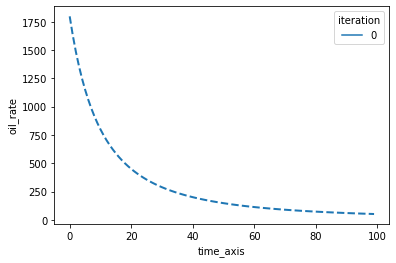

In [20]:
rng = np.random.default_rng(1706)
ne = 10 #number of ensemble
nt = 100 #timestep
nm = 3 # Model Parameters

tmax = 100
t = np.arange(tmax)
qi = 1800
di = 0.1
b = 0.5
true_params = np.array([qi,di,b])
dc1 = Arps(
    qi=qi,
    di=di,
    b = b,
    ti = 0
)

dc1.plot(
    start=0,
    end = 100,
    freq_input='M',
    freq_output='M'
)

In [21]:
fr = dc1.forecast(
    start=0,
    end = 100,
    freq_input='M',
    freq_output='M'
)
fr.shape

(100, 4)

In [22]:
sd = fr['oil_rate']*0.2
sd

date
0     360.000000
1     326.530612
2     297.520661
3     272.211720
4     250.000000
         ...    
95     10.888469
96     10.701546
97     10.519395
98     10.341856
99     10.168773
Name: oil_rate, Length: 100, dtype: float64

In [23]:
noise = rng.standard_normal(size=(fr.shape[0],))


In [24]:
fr['obs'] = fr['oil_rate'].values + noise * sd

<AxesSubplot:xlabel='date', ylabel='oil_rate'>

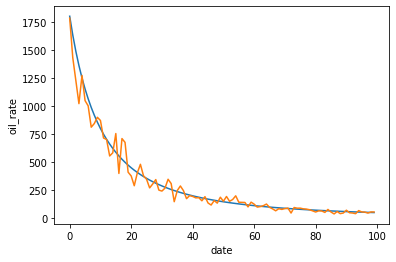

In [25]:
fig, ax = plt.subplots()
sns.lineplot(data=fr, x = fr.index, y=fr['oil_rate'],ax=ax)
sns.lineplot(data=fr, x = fr.index, y=fr['obs'],ax=ax)

In [26]:
true_params

array([1.8e+03, 1.0e-01, 5.0e-01])

In [27]:
def create_ensambles(n_ensambles,n_params,ranges):
    mf = rng.uniform(0.0,1.0, size=(n_params,n_ensambles))
    ma = np.zeros((n_params,n_ensambles))
    for i in range(n_params):
        range_diff = ranges[i][1] - ranges[i][0]
        ma[i,:] = ranges[i][0] + mf[i,:]*range_diff
        
    return ma
        
    

In [28]:
ne

10

In [29]:
m_range = [[1500,2000.0],[0.01,0.3],[1e-5,1.0]]
ens = create_ensambles(ne,len(m_range),m_range)
ens.T

array([[1.66280477e+03, 2.76657712e-01, 9.73709751e-01],
       [1.74367210e+03, 2.02185677e-01, 4.27471327e-01],
       [1.54557896e+03, 1.91243209e-01, 7.45277169e-01],
       [1.72394801e+03, 2.65378802e-01, 5.91510424e-01],
       [1.82915554e+03, 2.04691063e-02, 8.92476464e-01],
       [1.72320553e+03, 2.84342061e-01, 9.77087735e-01],
       [1.84698659e+03, 9.34449483e-02, 3.14731267e-01],
       [1.73313822e+03, 1.20923278e-01, 3.35938341e-01],
       [1.56436697e+03, 9.47207280e-02, 5.37383968e-01],
       [1.73817022e+03, 1.85347832e-01, 6.09566256e-01]])

In [30]:
    
def forward(ensambles,tmax):
    tt = np.arange(tmax)
    ne = ensambles.shape[1]
    curves = np.zeros((tmax,ne))

    for i in range(ne):
        curves[:,i] = arps_forecast(tt,*ensambles[:,i])
    
    return pd.DataFrame(curves,columns=np.arange(ne))
    
df = forward(ens,tmax)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,1662.804774,1743.672095,1545.578964,1723.948011,1829.155536,1723.205532,1846.986587,1733.138219,1564.366968,1738.170223
1,1301.520798,1436.302374,1292.545521,1347.317296,1792.426016,1340.813115,1684.482238,1539.414350,1426.312475,1458.237120
2,1068.105728,1200.817633,1103.927078,1086.568320,1757.067679,1096.285618,1540.266619,1373.565625,1306.137618,1244.353890
3,905.025320,1016.811042,958.623089,897.839595,1723.006497,926.588384,1411.855968,1230.748698,1200.853113,1076.803563
4,784.727003,870.563464,843.709792,756.397771,1690.173633,802.000762,1297.158660,1107.096578,1108.072707,942.801106


   index en         rate
0      0  0  1662.804774
1      1  0  1301.520798
2      2  0  1068.105728
3      3  0   905.025320
4      4  0   784.727003


<AxesSubplot:xlabel='index', ylabel='rate'>

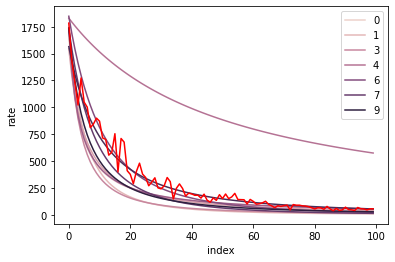

In [31]:
df_melt = df.reset_index().melt(id_vars='index',var_name='en',value_name='rate')
print(df_melt.head())

fig, ax = plt.subplots()
sns.lineplot(data=df_melt, x='index',y='rate', hue='en',ax=ax)
sns.lineplot(data=fr, x = fr.index, y=fr['obs'],ax=ax,color='red')

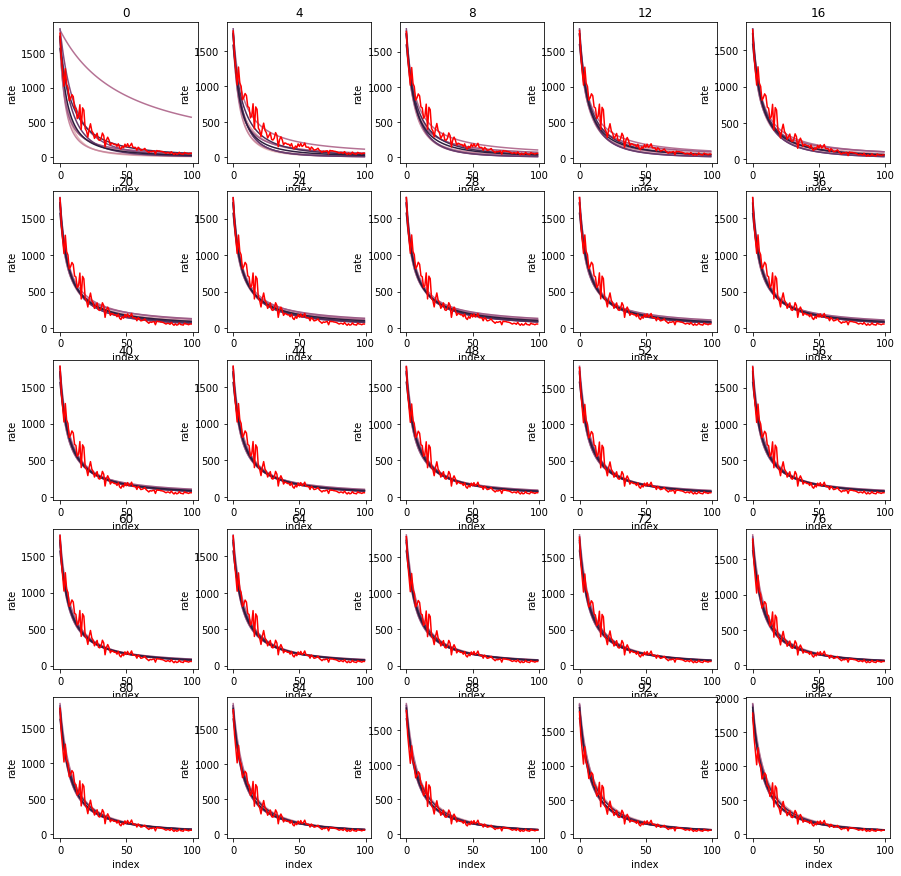

In [32]:
nd = 1
ind_hist = 99

ens_use = ens.copy()

fig, ax = plt.subplots(5,5,figsize=(15,15))
ax = ax.flatten()
c=0
for i in range(ind_hist):
    d_obs_i = fr['obs'].iloc[i].reshape(1,1)
    df_all = forward(ens_use,tmax)
    dfi = df_all.iloc[i,:].values.reshape((1,ne))
    m_b = ens_use.mean(axis=1).reshape((3,1)) #mean ensable props
    d_b = dfi.mean(axis=1) #Mean timestep i in all ensembles
    m_e = ens_use - m_b # difference ensemble and mean of ensembles
    d_e = dfi - d_b # difference sim data timestep all ensembles and its mean
    
    #3x500 500x1
    cmd = np.matmul(m_e,d_e.T)/(ne-1)
    
    #1x500 500x1
    cdd = np.matmul(d_e,d_e.T)/(ne-1)
    
    #kalman Gain 3X1
    # k_gain = cmd/(np.square(sd.iloc[i])+cdd[0,0])
    k_gain = cmd/(np.square(sd.iloc[i])+cmd)
    epsi = rng.standard_normal((1,1))*sd.iloc[i]
    
    #3x1 1x500
    ens_use = ens_use + np.matmul(k_gain,d_obs_i+epsi-dfi)
    
    if i%4==0:
        df_melt = df_all.reset_index().melt(id_vars='index',var_name='en',value_name='rate')
        sns.lineplot(data=df_melt, x='index',y='rate', hue='en',ax=ax[c],legend=False) 
        sns.lineplot(data=fr, x = fr.index, y=fr['obs'],ax=ax[c],color='red')
        ax[c].set_title(f'{i}')
        c+=1
    



In [36]:
ens_df = pd.DataFrame(
    np.concatenate((ens.T,ens_use.T),axis=0),
    columns=['qi','di','b']
)
ens_df.loc[0:ne-1,'type'] = 'initial'
ens_df.loc[ne:,'type'] = 'final'
ens_df.reset_index(inplace=True)
ens_df_melt = ens_df.melt(
    id_vars=['index','type'],
    value_vars=['qi','di','b'],
    value_name='values',
    var_name='props'
)
ens_df_melt

,index,type,props,values
0,0,initial,qi,1662.804774
1,1,initial,qi,1743.672095
2,2,initial,qi,1545.578964
3,3,initial,qi,1723.948011
4,4,initial,qi,1829.155536
5,5,initial,qi,1723.205532
6,6,initial,qi,1846.986587
7,7,initial,qi,1733.138219
8,8,initial,qi,1564.366968
9,9,initial,qi,1738.170223


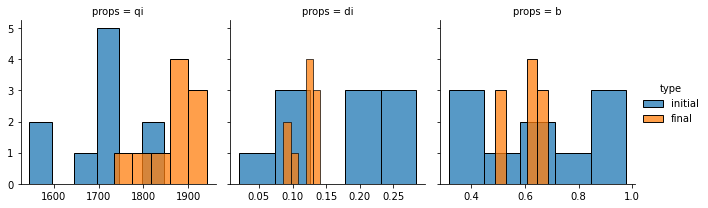

In [37]:
g = sns.FacetGrid(
    data = ens_df_melt,
    col='props',
    hue = 'type',
    sharex=False
)
g.map_dataframe(sns.histplot,x='values')
g.add_legend()